In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
import keras
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU
import src.pcam_loader as data
import numpy as np
import pandas as pd
import imageio
from IPython.display import Image


Using TensorFlow backend.


## Load pcam data

In [2]:
# Load data from /User/Username/.keras/datasets/pcam
dataset = data.load_data()
x_train, y_train, meta_train =  dataset[0]
x_valid, y_valid, meta_valid =  dataset[1]
x_test, y_test, meta_test =  dataset[2]

In [3]:
y_train = np.array(y_train[:])
y_train = y_train.reshape(-1, 1)
y_valid = np.array(y_valid[:])
y_valid = y_valid.reshape(-1, 1)
y_test = np.array(y_test[:])
y_test = y_test.reshape(-1, 1)

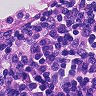

In [4]:
## Save data into png format and visualize image
# imageio.imwrite('image.png', )
Image(filename='image.png') 

In [5]:
print(meta_train.head(5), '\n')
print(meta_train.info())

# Shape of train, valid and test input are the same, don't need to preprocess
print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)


   Unnamed: 0  coord_y  coord_x  tumor_patch  center_tumor_patch  \
0           0    63104    43648        False               False   
1           1   148544    74048         True                True   
2           2    64192    78912         True                True   
3           3    98048    72128         True                True   
4           4    27264    50688        False               False   

                           wsi  
0   camelyon16_train_tumor_104  
1   camelyon16_train_tumor_003  
2   camelyon16_train_tumor_089  
3   camelyon16_train_tumor_004  
4  camelyon16_train_normal_118   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 6 columns):
Unnamed: 0            262144 non-null int64
coord_y               262144 non-null int64
coord_x               262144 non-null int64
tumor_patch           262144 non-null bool
center_tumor_patch    262144 non-null bool
wsi                   262144 non-null object
dtypes: bool(2), i

## Build model

In [6]:
batch_size = 64
epochs = 10
num_classes = 2

In [7]:
# Simple CNN with 3 Convolutional layers and 2 Full connected layers
input_layer =  Input(shape=(96, 96, 3))

conv1 = Conv2D(32, (3, 3), padding='same', activation='linear')(input_layer)
conv1 = LeakyReLU(alpha=0.1)(conv1)
conv1 = MaxPool2D((2, 2))(conv1)
conv1 = Dropout(0.25)(conv1)

conv2 = Conv2D(64, (3, 3), padding='same', activation='linear')(conv1)
conv2 = LeakyReLU(alpha=0.1)(conv2)
conv2 = MaxPool2D((2, 2))(conv2)
conv2 = Dropout(0.25)(conv2)

conv3 = Conv2D(64, (5, 5), padding='same', activation='linear')(conv2)
conv3 = LeakyReLU(alpha=0.1)(conv3)
conv3 = MaxPool2D((2, 2))(conv3)
conv3 = Dropout(0.25)(conv3)

conv4 = Conv2D(128, (5, 5), padding='same', activation='linear')(conv3)
conv4 = LeakyReLU(alpha=0.1)(conv4)
conv4 = MaxPool2D((2, 2))(conv4)
conv4 = Dropout(0.25)(conv4)

dense1 = Flatten()(conv3)
dense1 = Dense(128, activation='linear')(dense1)
dense1 = LeakyReLU(alpha=0.1)(dense1)

dense2 = Dense(num_classes, activation='softmax')(dense1)
# dense2 = Dense(1, activation='sigmoid')(dense1)

model = Model(input=[input_layer], output=[dense2])
model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0   

C:\Users\matho\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


### Train the model

In [8]:

model.fit(
    x_train,
    to_categorical(y_train),
    # batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, to_categorical(y_valid)),
    shuffle='batch'
)

Train on 262144 samples, validate on 32768 samples
Epoch 1/5
262144/262144 [==============================] - 5222s 20ms/step - loss: 0.9461 - accuracy: 0.5007 - val_loss: 0.6936 - val_accuracy: 0.4995

In [10]:
model.save("model_3_LeakyRelu.h5")

In [13]:
test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 0.6932164088939317
Test accuracy: 0.499786376953125
